# Extracción de tópicos



El *topic modeling* es una técnica en el campo del procesamiento del lenguaje natural (NLP) que se utiliza para descubrir temas o "tópicos" ocultos en un conjunto de documentos de texto. Esta técnica ayuda a identificar patrones y estructuras temáticas dentro de grandes volúmenes de texto no etiquetado, permitiendo agrupar palabras que tienden a aparecer juntas y asociarlas con posibles temas o categorías.

Las técnicas más comunes para realizar *topic modeling* incluyen:

1. **Latent Dirichlet Allocation (LDA)**: Es un algoritmo generativo que asume que cada documento es una mezcla de temas y que cada tema es una distribución de palabras. LDA busca asignar probabilidades a palabras y documentos para identificar los temas más probables en función de la co-ocurrencia de palabras.

2. **Non-negative Matrix Factorization (NMF)**: Otra técnica común para descomponer la matriz de documentos y palabras, basada en el principio de que los datos pueden ser expresados como la suma de componentes no negativos. A menudo es utilizada cuando se busca interpretabilidad en los resultados.

3. **Latent Semantic Analysis (LSA)**: Utiliza descomposición en valores singulares (SVD) para identificar relaciones semánticas entre los términos de un conjunto de documentos y generar representaciones de temas.

El resultado del *topic modeling* son grupos de palabras clave que describen los temas predominantes en los documentos, lo que facilita la comprensión del contenido sin necesidad de una revisión manual exhaustiva.

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [33]:
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [89]:
def measure_time_start():
  return time()

def measure_time_end(t0):
  print("done in %0.2fs." % (time() - t0))
  print()

In [98]:
def plot_top_words(model, feature_names, n_top_words, title):

  fig, axes = plt.subplots(2, 5, figsize=(16, 5), sharex=True)
  axes = axes.flatten()

  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[-n_top_words:]
    top_features = feature_names[top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic { topic_idx + 1 }", fontdict={"fontsize": 10})
    ax.tick_params(axis="both", which="major", labelsize=8)
    for i in "top right left".split():
      ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=12)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()

In [76]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 12
batch_size = 128
init = "nndsvda"

In [90]:
# Load the 20 newsgroups dataset and vectorize it.
# We use a few heuristics to filter out useless terms early on: the posts are stripped of headers, footers and quoted replies,
# and common English words, words occurring in only one document or in at least 95% of the documents are removed.
print("Loading dataset...")
t0 = measure_time_start()
data, _ = fetch_20newsgroups(shuffle=True, remove=("headers", "footers", "quotes"), return_X_y=True, random_state=1)
data_samples = data[:n_samples]
measure_time_end(t0)

Loading dataset...
done in 1.30s.



In [91]:
# Use TF-IDF features for NMF
print("Extracting TF-IDF features for NMF...")
t0 = measure_time_start()
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(data_samples)
measure_time_end(t0)

Extracting TF-IDF features for NMF...
done in 0.58s.



In [92]:
# Use TF (raw term count) features for LDA
print("Extracting TF features for LDA...")
t0 = measure_time_start()
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tf = tf_vectorizer.fit_transform(data_samples)
measure_time_end(t0)

Extracting TF features for LDA...
done in 0.36s.



Fitting NMF model (Frobenius norm) with TF-IDF features, n_samples=2000 and n_features=1000
done in 0.16s.



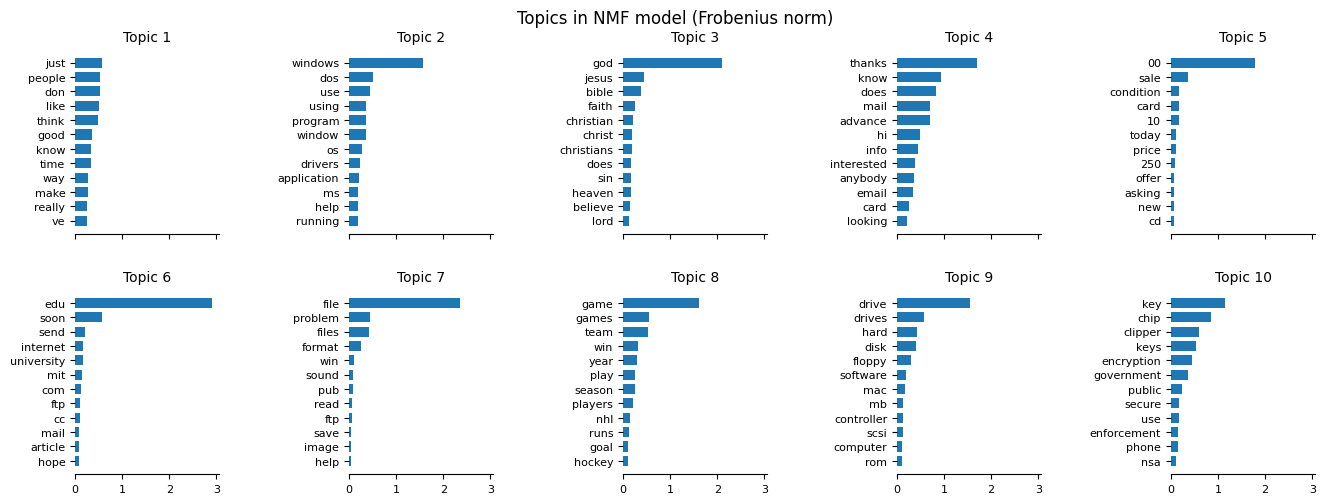

In [106]:
# Fit the NMF model
print("Fitting NMF model (Frobenius norm) with TF-IDF features, n_samples=%d and n_features=%d" % (n_samples, n_features))
t0 = measure_time_start()
nmf = NMF(n_components=n_components, init=init, beta_loss="frobenius", alpha_W=0.00005, alpha_H=0.00005, l1_ratio=1, random_state=1)
model = nmf.fit(tfidf)
measure_time_end(t0)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(model, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")

Fitting NMF model (generalized Kullback-Leibler divergence) with TF-IDF features, n_samples=2000 and n_features=1000
done in 3.24s.



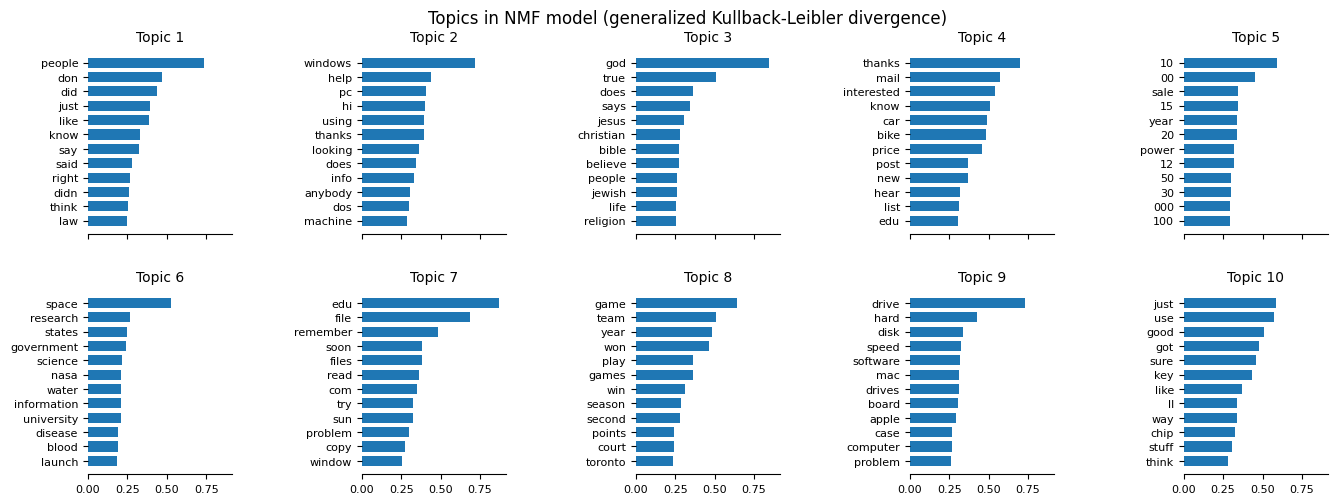

In [107]:
# Fit the NMF model
print("Fitting NMF model (generalized Kullback-Leibler divergence) with TF-IDF features, n_samples=%d and n_features=%d" % (n_samples, n_features))
t0 = measure_time_start()
nmf = NMF(n_components=n_components, init=init, beta_loss="kullback-leibler", solver="mu", max_iter=1000, alpha_W=0.00005, alpha_H=0.00005, l1_ratio=0.5, random_state=1)
model = nmf.fit(tfidf)
measure_time_end(t0)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(model, tfidf_feature_names, n_top_words, "Topics in NMF model (generalized Kullback-Leibler divergence)")

Fitting MiniBatchNMF model (Frobenius norm) with TF-IDF features, n_samples=2000 and n_features=1000, batch_size=128
done in 0.16s.



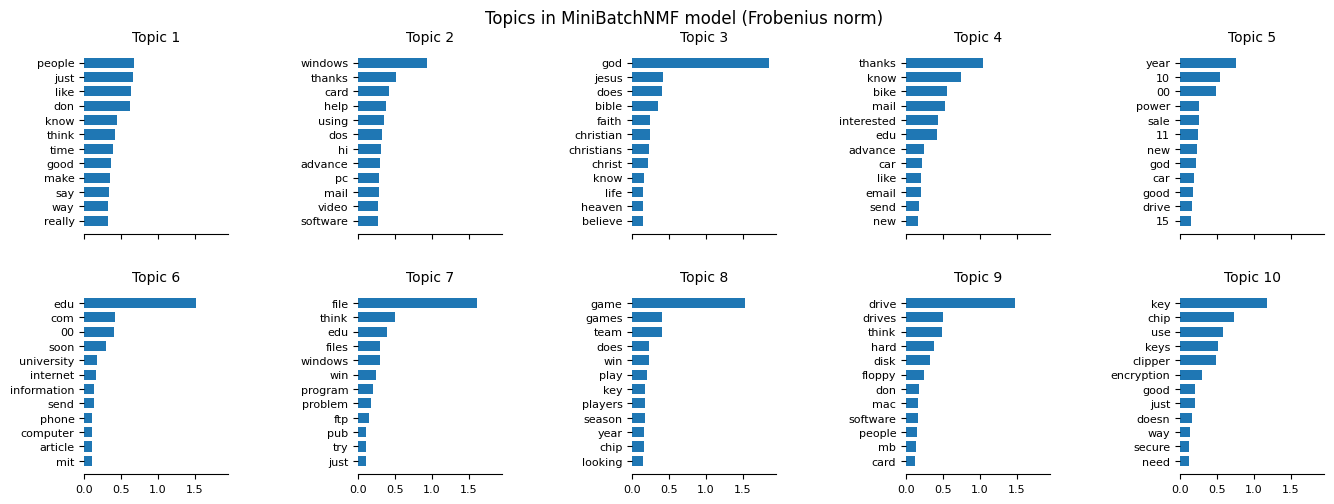

In [108]:
# Fit the MiniBatchNMF model
print("Fitting MiniBatchNMF model (Frobenius norm) with TF-IDF features, n_samples=%d and n_features=%d, batch_size=%d" % (n_samples, n_features, batch_size))
t0 = measure_time_start()
mbnmf = MiniBatchNMF(n_components=n_components, random_state=1, batch_size=batch_size, init=init, beta_loss="frobenius", alpha_W=0.00005, alpha_H=0.00005, l1_ratio=0.5)
model = mbnmf.fit(tfidf)
measure_time_end(t0)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(model, tfidf_feature_names, n_top_words, "Topics in MiniBatchNMF model (Frobenius norm)")

Fitting MiniBatchNMF model (generalized Kullback-Leibler divergence) with TF-IDF features, n_samples=2000 and n_features=1000, batch_size=128
done in 0.39s.



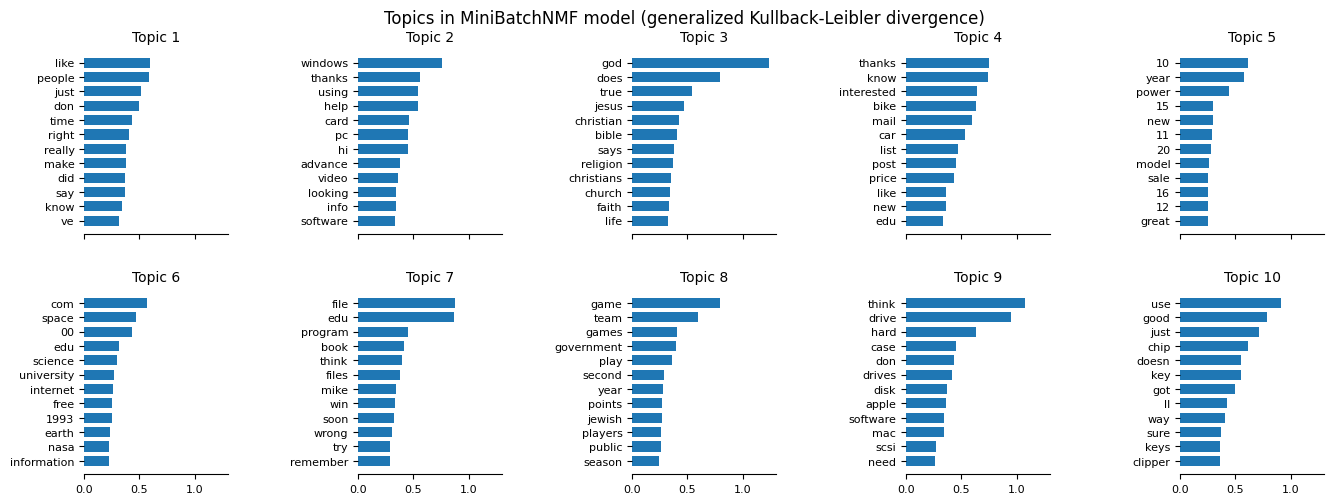

In [109]:
# Fit the MiniBatchNMF model
print("Fitting MiniBatchNMF model (generalized Kullback-Leibler divergence) with TF-IDF features, n_samples=%d and n_features=%d, batch_size=%d" % (n_samples, n_features, batch_size))
t0 = measure_time_start()
mbnmf = MiniBatchNMF(n_components=n_components, batch_size=batch_size, init=init, beta_loss="kullback-leibler", alpha_W=0.00005, alpha_H=0.00005, l1_ratio=0.5, random_state=1)
model = mbnmf.fit(tfidf)
measure_time_end(t0)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(model, tfidf_feature_names, n_top_words, "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)")

Fitting LDA models with TF features, n_samples=2000 and n_features=1000
done in 2.95s.



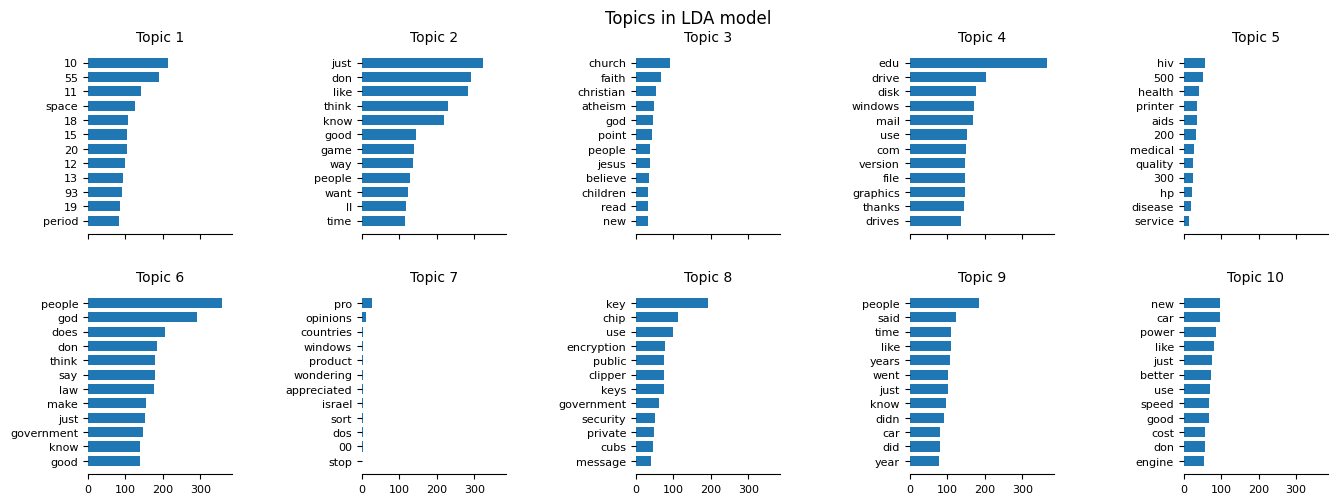

In [110]:
# Fit LDA model
print("Fitting LDA models with TF features, n_samples=%d and n_features=%d" % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method="online", learning_offset=50.0, random_state=0)
t0 = measure_time_start()
lda.fit(tf)
measure_time_end(t0)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")